# Analysis of titanic data specified in kaggle: https://www.kaggle.com/c/titanic
This notebook presents a profound exploratory analysis of the dataset in order to provide understanding of the dependencies and interesting facts.

Four ML techniques are used to do prediction: RandomForest, LogisticRegression, KNeighbours and the Ensembl.

LogisticRegression performed the best with a score of 0.80383.


In [1]:
import pandas as pd
import numpy as np
import collections, re
import copy


from cycler import cycler
from pandas.tools.plotting import scatter_matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline  

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

from sklearn.grid_search import GridSearchCV

pd.set_option('display.max_columns', 500)

/Users/kokatjuhha/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/kokatjuhha/miniconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
train = pd.read_csv('~/Desktop/train.csv')
test = pd.read_csv('~/Desktop/test.csv')


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


# 1. Exploratory analysis
## 1.1 Basic Information about the table

In [4]:
train.head(8)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Average Age is 29 years and ticket price is 32.
As there are 681 unique tickets and there is no way to extract less detailed information we exclude this variable. There are 891 Name and we will have a look on the title of each passenger.

In [6]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Graham, Mr. George Edward",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


## 1.2 Survival by Sex and Age
#### A citate from a movie: 'Children and women first'. 
* Survival rate of passengers under 13 is higher and between 13 and 30 is lower. Take it into consideration while engineering the variable: we could specify a categorical variable as young and adult.
* For women the survival chances are higher between 14 and 40 age. For men of the same age the survival chances are less. Factor plot shows us as well that survival rate of women is higher.

Survived
0    Axes(0.125,0.125;0.775x0.775)
1    Axes(0.125,0.125;0.775x0.775)
Name: Age, dtype: object

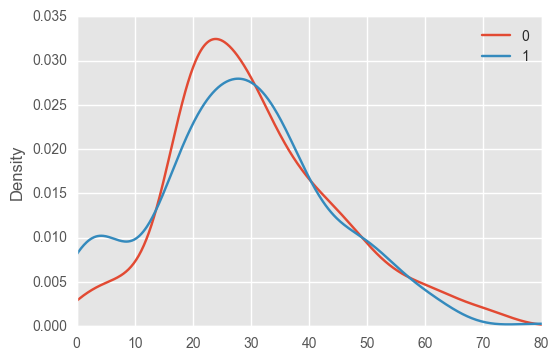

In [7]:
train.groupby("Survived").Age.plot(kind='kde', legend = True, xlim = (0,80))

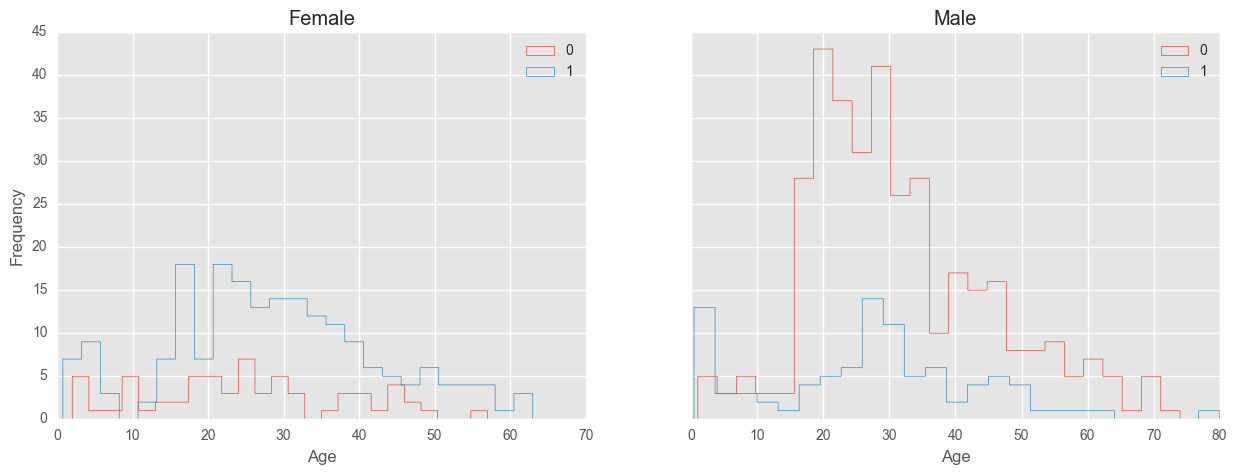

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True,figsize=(15, 5))
females = train[train['Sex']=='female']
males = train[train['Sex']=='male']

females_age = females.groupby("Survived").Age
males_age = males.groupby("Survived").Age

females_age.plot(kind='hist', legend = True, histtype='step', ax=axes[0], title = 'Female', bins = 25)
axes[0].set_xlabel('Age')
males_age.plot(kind='hist', legend = True, histtype='step', ax=axes[1], title = 'Male', bins = 25)
axes[1].set_xlabel('Age')

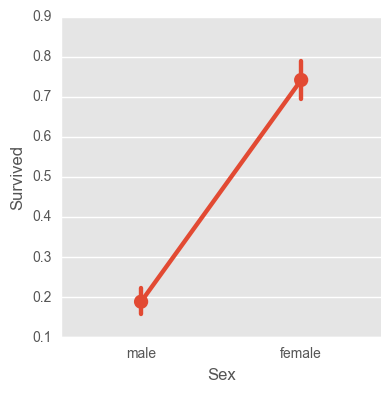

In [9]:
sns.factorplot('Sex','Survived', data=train)

## 1.3 Survival by Class,  Embarked and Fare.
* Survival rate is higher if a person was a woman who a first or second class ticket. Except for the embarked Q where women from the 3rd class still had a quite high survival rate.
* In fact, there is a very high variation in survival rate in embarked Q among 1st and 2nd class. The third class had the same survival rate as the 3rd class embarked C. We will exclude this variable embarked Q. From crosstab we see that there were only 5 passengers in embarked Q with the 1st and 2nd class. That explains the 1.0 and 0.0 survival rate in factorplots.
* Also, it appears that the higher the fare was in the first class the more chances a person had to survive.

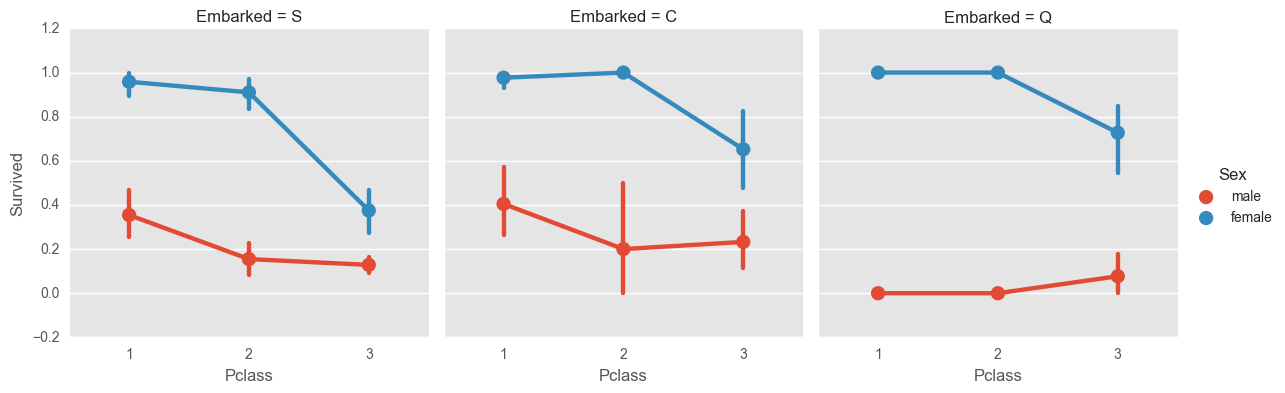

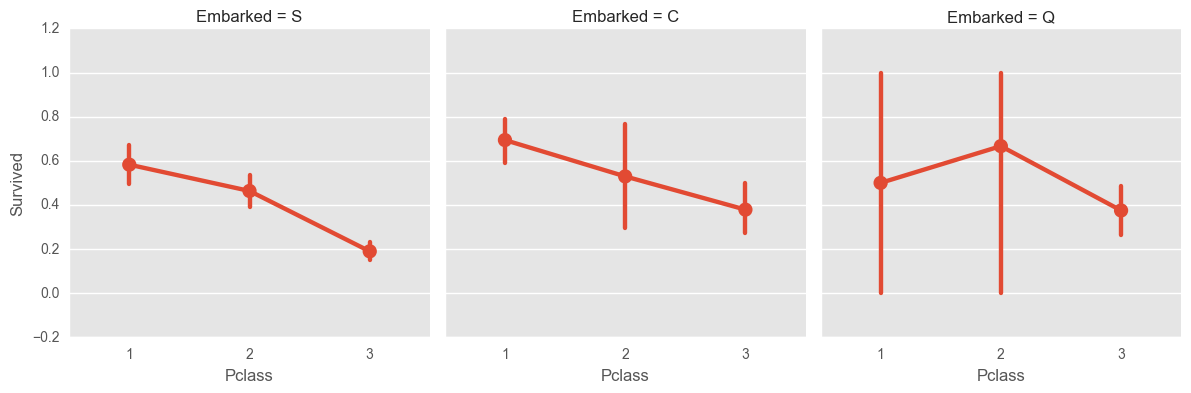

In [10]:
sns.factorplot('Pclass', 'Survived', hue='Sex', col = 'Embarked', data=train)
sns.factorplot('Pclass', 'Survived', col = 'Embarked', data=train)

Pclass      1    2    3
Embarked               
C          85   17   66
Q           2    3   72
S         127  164  353


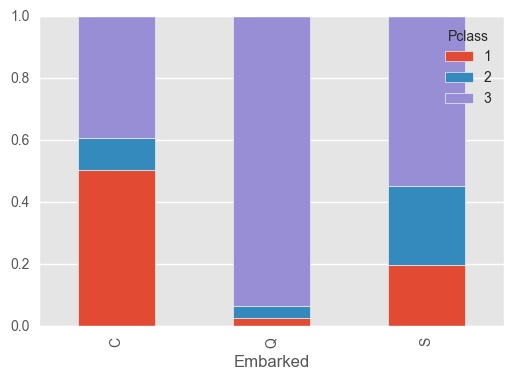

In [11]:
tab = pd.crosstab(train['Embarked'],train['Pclass'])
print(tab)
tab_prop = tab.div(tab.sum(1).astype(float), axis=0)
tab_prop.plot(kind="bar", stacked=True)

## 1.3.1 Class and age distribution

Interesting note that Age decreases with the Pclass decrease. One could do a derived feature Age*Class.

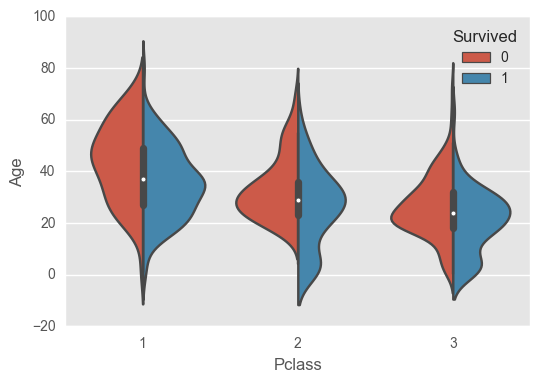

In [13]:
sns.violinplot(x='Pclass', y='Age', hue = 'Survived', data=train, split=True)

## 1.4 Survival rate regarding the family members
Assumption: the less people was in your family the faster you were to get to the boat. The more people they are the more managment is required. However, if you had no family members you might wanted to help others and therefore sacrifice.

* The females traveling with up to 2 more family members had a higher chance to survive. However, a high variation of survival rate appears once family size exceeds 4 as mothers/daughters would search longer for the members and therefore the chanes for survival decrease.
* Alone men might want to sacrifice and help other people to survive. 

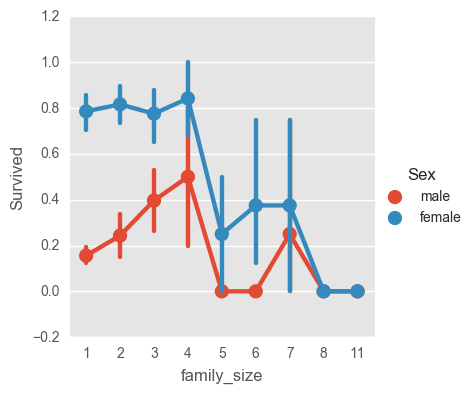

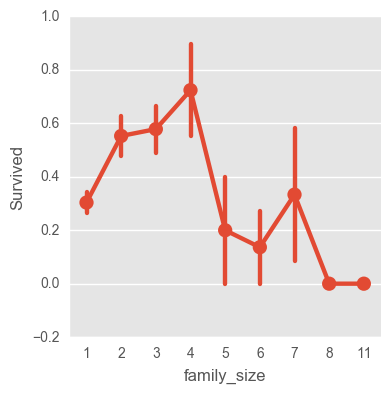

In [14]:
# To get the full family size of a person, added siblings and parch.
from statsmodels.graphics.mosaicplot import mosaic
train['family_size'] = train['SibSp'] + train['Parch'] + 1 
test['family_size'] = test['SibSp'] + test['Parch'] + 1 
sns.factorplot('family_size','Survived', hue = 'Sex', data=train)
sns.factorplot('family_size','Survived', data=train)

## 1.5 Survival rate by the title
* Barplots show that roalties had normally 1st or 2nd class tickets. However, people with the title Master had mostly 3rd class. In fact, a title 'Master' was given to unmarried boys. You can see that the age of of people with this title is less than 13.
* Women and roalties had higher survival rate. (There are only two titlted women in the train class and both have survived, I would put them into Mrs class)
* The civils and reverends a lower one due to the fact that they had/wanted to help people.

In [15]:
train['Title'] = train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
print(collections.Counter(train['Title']).most_common())
test['Title'] = test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
print()
print(collections.Counter(test['Title']).most_common())

[('Mr', 517), ('Miss', 182), ('Mrs', 125), ('Master', 40), ('Dr', 7), ('Rev', 6), ('Major', 2), ('Mlle', 2), ('Col', 2), ('Sir', 1), ('Don', 1), ('Capt', 1), ('Lady', 1), ('Jonkheer', 1), ('Countess', 1), ('Ms', 1), ('Mme', 1)]
()
[('Mr', 240), ('Miss', 78), ('Mrs', 72), ('Master', 21), ('Rev', 2), ('Col', 2), ('Dr', 1), ('Dona', 1), ('Ms', 1)]


Pclass      1   2    3
Title                 
Capt        1   0    0
Col         2   0    0
Countess    1   0    0
Don         1   0    0
Dr          5   2    0
Jonkheer    1   0    0
Lady        1   0    0
Major       2   0    0
Master      3   9   28
Miss       46  34  102
Mlle        2   0    0
Mme         1   0    0
Mr        107  91  319
Mrs        42  41   42
Ms          0   1    0
Rev         0   6    0
Sir         1   0    0


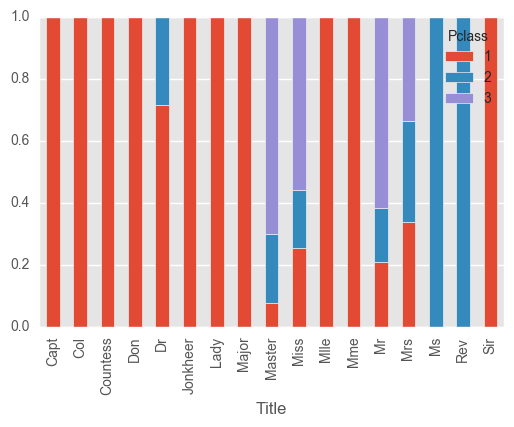

In [16]:
tab = pd.crosstab(train['Title'],train['Pclass'])
print(tab)
tab_prop = tab.div(tab.sum(1).astype(float), axis=0)
tab_prop.plot(kind="bar", stacked=True)

Investigate who were masters. The age is less than 12.

In [17]:
max(train[train['Title']== 'Master'].Age)

12.0

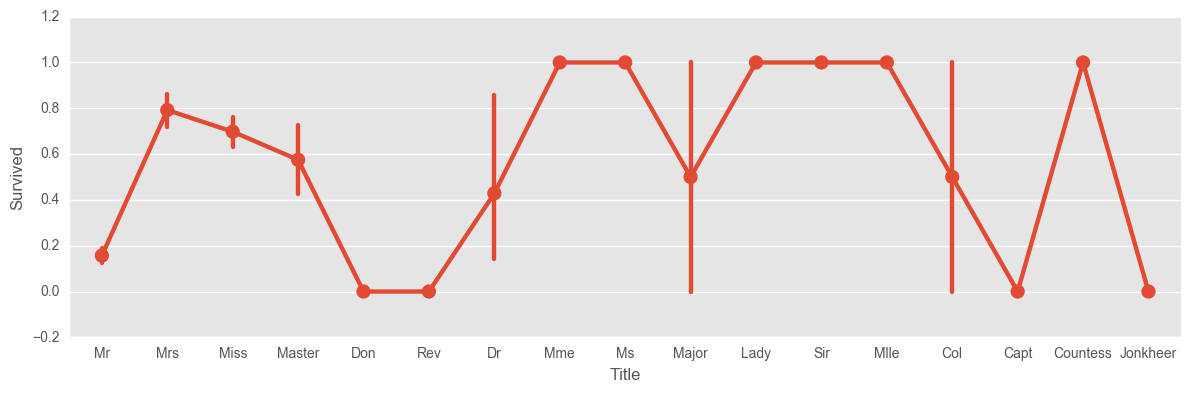

In [18]:
sns.factorplot('Title','Survived', data=train, aspect =3)

We will group the roalties and assign masters to Mr and due to the fact that there were not so many roaly women, we will assign then to Mrs.

In [19]:
#train['Title'].replace(['Master','Major', 'Capt', 'Col', 'Countess','Dona','Lady', 'Don', 'Sir', 'Jonkheer', 'Dr'], 'titled', inplace = 'True')
train['Title'].replace(['Master','Major', 'Capt', 'Col','Don', 'Sir', 'Jonkheer', 'Dr'], 'titled', inplace = 'True')
#train['Title'].replace(['Countess','Dona','Lady'], 'titled_women', inplace = 'True')
#train['Title'].replace(['Master','Major', 'Capt', 'Col','Don', 'Sir', 'Jonkheer', 'Dr'], 'titled_man', inplace = 'True')
train['Title'].replace(['Countess','Dona','Lady'], 'Mrs', inplace = 'True')
#train['Title'].replace(['Master'], 'Mr', inplace = 'True')
train['Title'].replace(['Mme'], 'Mrs', inplace = 'True')
train['Title'].replace(['Mlle','Ms'], 'Miss', inplace = 'True')

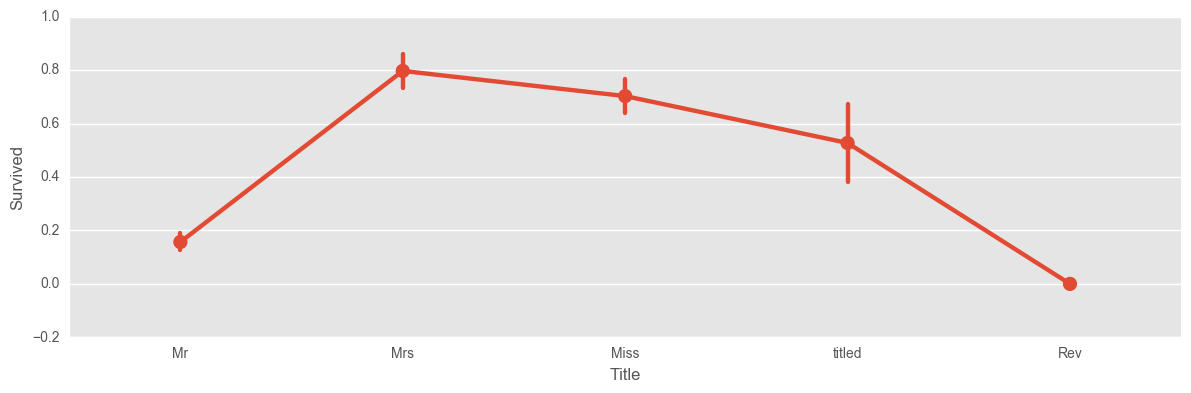

In [20]:
sns.factorplot('Title','Survived', data=train, aspect =3)

## 1.6 Survival rate by cabin
Cabin is supposed to be less distingushing, also taking into consideration that most of the values are missing.

Cabin_l
A         15
B         47
C         59
D         33
E         32
F         13
G          4
T          1
other    687
dtype: int64


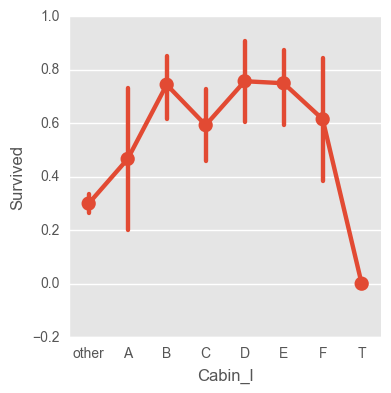

In [21]:
def extract_cabin(x):
    return x!=x and 'other' or x[0]
train['Cabin_l'] = train['Cabin'].apply(extract_cabin)
print(train.groupby('Cabin_l').size())
sns.factorplot('Cabin_l','Survived', data=train, order = ['other', 'A','B', 'C', 'D', 'E', 'F', 'T' ])

## 1.7 Correlation of the variables
* Pclass is slightly correlated with Fare as logically, 3rd class ticket would cost less than the 1st class.
* Pclass is also slightly correlated with Survived
* SibSp and Parch are weakly correlated as basically they show how big the family size is.


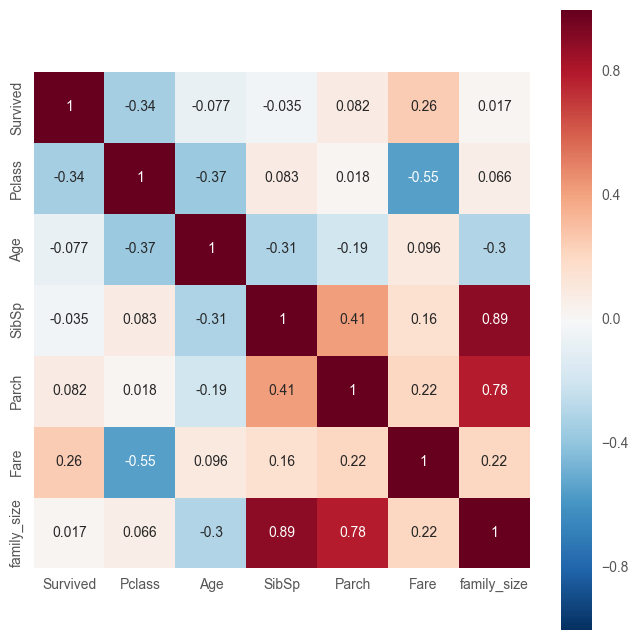

In [22]:
plt.figure(figsize=(8, 8))
corrmap = sns.heatmap(train.drop('PassengerId',axis=1).corr(),square=True, annot=True)

## 2. FEATURE SELECTION AND ENGINEERING
## 2.1 Impute values
First, we check how many nas there is in general. If there is only small amount then we can just exclude those individuals. Considering that there are 891 training samples, 708 do not have missing values. 183 samples have na values. It is better to impute. There are different techniques one can impute the values.

In [23]:
train.shape[0] - train.dropna().shape[0]

708

Check wich columns to impute in which set. It shows the number of na-values in each column.

In [24]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
family_size      0
Title            0
Cabin_l          0
dtype: int64

In [25]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
family_size      0
Title            0
dtype: int64

Embarked: fill embarked with a major class

In [26]:
max_emb = np.argmax(train['Embarked'].value_counts())
train['Embarked'].fillna(max_emb, inplace=True)

Pclass: because there is only one missing value in Fare we will fill it with a median of the corresponding Pclass

In [27]:
indz = test['Fare'].index[test['Fare'].apply(np.isnan)].tolist
print(indz)
pclass = test['Pclass'][152]
fare_test = test[test['Pclass']==pclass].Fare.dropna()
fare_train = train[train['Pclass']==pclass].Fare
fare_med = (fare_test + fare_train).median()
print(fare_med)
test.loc[152,'Fare'] = fare_med

<bound method Int64Index.tolist of Int64Index([152], dtype='int64')>
20.98335


Age:
fill age with generated random number between (mean - std) & (mean + std)

In [28]:
ages = np.concatenate((test['Age'].dropna(), train['Age'].dropna()), axis=0)
std_ages = ages.std()
mean_ages = ages.mean()
train_nas = np.isnan(train["Age"])
test_nas = np.isnan(test["Age"])
np.random.seed(122)
impute_age_train  = np.random.randint(mean_ages - std_ages, mean_ages + std_ages, size = train_nas.sum())
impute_age_test  = np.random.randint(mean_ages - std_ages, mean_ages + std_ages, size = test_nas.sum())
train["Age"][train_nas] = impute_age_train
test["Age"][test_nas] = impute_age_test
ages_imputed = np.concatenate((test["Age"],train["Age"]), axis = 0)

/Users/kokatjuhha/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/kokatjuhha/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [29]:
train['Age*Class'] = train['Age']*train['Pclass']
test['Age*Class'] = test['Age']*test['Pclass']

Check if we disrupted the distribution somehow.

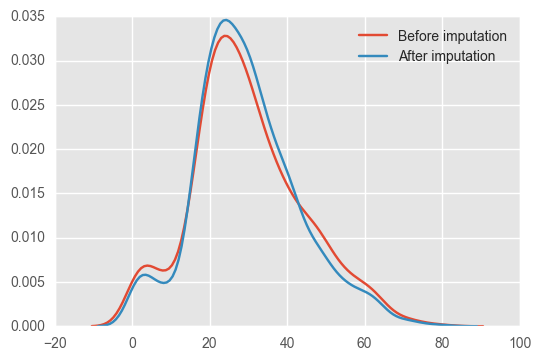

In [30]:
sns.kdeplot(ages,label = 'Before imputation')
sns.kdeplot(ages_imputed, label = 'After imputation')

## 2.2 ENGENEER VALUES

Integrate into test the title feature

In [31]:
test['Title'] = test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

test['Title'].replace(['Master','Major', 'Capt', 'Col','Don', 'Sir', 'Jonkheer', 'Dr'], 'titled', inplace = 'True')
test['Title'].replace(['Countess','Dona','Lady'], 'Mrs', inplace = 'True')
#test['Title'].replace(['Master'], 'Mr', inplace = 'True')
test['Title'].replace(['Mme'], 'Mrs', inplace = 'True')
test['Title'].replace(['Mlle','Ms'], 'Miss', inplace = 'True')


Seperate young and adult people

In [32]:
train['age_cat'] = None
train.loc[(train['Age'] <= 13), 'age_cat'] = 'young'
train.loc[ (train['Age'] > 13), 'age_cat'] = 'adult'

test['age_cat'] = None
test.loc[(test['Age'] <= 13), 'age_cat'] = 'young'
test.loc[(test['Age'] > 13), 'age_cat'] = 'adult'

Drop broaden variables. As we have seen from describe there are too many unique values for Ticket and missing values for Cabin

In [33]:
train_label = train['Survived']
test_pasId = test['PassengerId']
drop_cols = ['Name','Ticket', 'Cabin', 'SibSp', 'Parch', 'PassengerId']
train.drop(drop_cols + ['Cabin_l'], 1, inplace = True)
test.drop(drop_cols, 1, inplace = True)

Convert Pclass into categorical variable

In [34]:
train['Pclass'] = train['Pclass'].apply(str)
test['Pclass'] = test['Pclass'].apply(str)

Create dummy variables for categorical data.

In [35]:
train.drop(['Survived'], 1, inplace = True)
train_objs_num = len(train)
dataset = pd.concat(objs=[train, test], axis=0)
dataset = pd.get_dummies(dataset)
train = copy.copy(dataset[:train_objs_num])
test = copy.copy(dataset[train_objs_num:])

In [36]:
droppings = ['Embarked_Q', 'Age']
#droppings += ['Sex_male', 'Sex_female']

test.drop(droppings, 1, inplace = True)
train.drop(droppings,1, inplace = True)

In [37]:
train.head(5)

,Fare,family_size,Age*Class,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rev,Title_titled,age_cat_adult,age_cat_young
0,7.2500,2,66.0,0,0,1,0,1,0,1,0,1,0,0,0,1,0
1,71.2833,2,38.0,1,0,0,1,0,1,0,0,0,1,0,0,1,0
2,7.9250,1,78.0,0,0,1,1,0,0,1,1,0,0,0,0,1,0
3,53.1000,2,35.0,1,0,0,1,0,0,1,0,0,1,0,0,1,0
4,8.0500,1,105.0,0,0,1,0,1,0,1,0,1,0,0,0,1,0


## CLASSIFICATION

In [38]:
def prediction(model, train, label, test, test_pasId):
    model.fit(train, label)
    pred = model.predict(test)
    accuracy = cross_val_score(model, train, label, cv = 5)

    sub = pd.DataFrame({
            "PassengerId": test_pasId,
            "Survived": pred
        })    
    return [model, accuracy, sub]

## 1. Random Forest
There are many categorical features, so I have chosen random forest to do the classification.

               importance
feature                  
Age*Class           0.190
Fare                0.170
Sex_male            0.152
Title_Mr            0.141
Sex_female          0.077
family_size         0.074
Pclass_3            0.051
Pclass_1            0.025
Title_Mrs           0.024
Title_Miss          0.021
Embarked_S          0.017
Pclass_2            0.015
age_cat_adult       0.011
Title_titled        0.010
Embarked_C          0.010
age_cat_young       0.008
Title_Rev           0.003
[ 0.7877095   0.79888268  0.87078652  0.81460674  0.84180791]


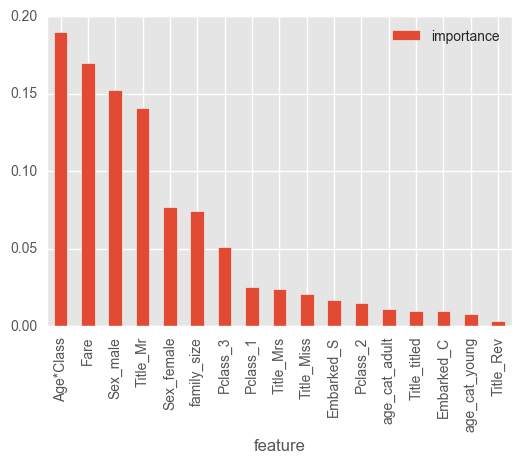

In [39]:
rf = RandomForestClassifier(n_estimators=80, min_samples_leaf = 2, min_samples_split=2, random_state=110)
acc_random_forest = prediction(rf, train, train_label, test, test_pasId)
importances = pd.DataFrame({'feature':train.columns,'importance':np.round(rf.feature_importances_,3)})
importances = importances.sort_values('importance', ascending=False).set_index('feature')
#acc_random_forest[2].to_csv('~/Desktop/random_forest.txt', index=False)
print (importances)
importances.plot.bar()
print(acc_random_forest[1])

test_predictions = acc_random_forest[0].predict(test)
test_predictions = test_predictions.astype(int)
submission = pd.DataFrame({
        "PassengerId": test_pasId,
        "Survived": test_predictions
    })

submission.to_csv("titanic_submission_randomforest.csv", index=False)

## 2. Logistic Regression

Classical logistic regression.

In [40]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(train['Fare'].values.reshape(-1, 1))
train['Fare'] = scaler.transform(train['Fare'].values.reshape(-1, 1)) 
test['Fare'] = scaler.transform(test['Fare'].values.reshape(-1, 1))  

scaler = StandardScaler().fit(train['Age*Class'].values.reshape(-1, 1))
train['Age*Class'] = scaler.transform(train['Age*Class'].values.reshape(-1, 1)) 
test['Age*Class'] = scaler.transform(test['Age*Class'].values.reshape(-1, 1))  



lr  = LogisticRegression(random_state=110)
acc = prediction(lr, train, train_label, test, test_pasId)
print(acc[1])

test_predictions = acc[0].predict(test)
test_predictions = test_predictions.astype(int)
submission = pd.DataFrame({
        "PassengerId": test_pasId,
        "Survived": test_predictions
    })
submission.to_csv("titanic_submission_logregres.csv", index=False)

#train.columns.tolist()
print(list(zip(acc[0].coef_[0], train.columns.tolist())))


[ 0.80446927  0.81005587  0.78651685  0.82022472  0.84180791]
[(0.25396667655642474, 'Fare'), (-0.41864159578743804, 'family_size'), (-0.36361236422877397, 'Age*Class'), (0.65917482107435588, 'Pclass_1'), (0.31565689689950122, 'Pclass_2'), (-0.40409641520967232, 'Pclass_3'), (1.2072011590413296, 'Sex_female'), (-0.63646585627714924, 'Sex_male'), (0.055222518918984539, 'Embarked_C'), (-0.3403932304160644, 'Embarked_S'), (0.11775091764254017, 'Title_Miss'), (-0.71835154910749499, 'Title_Mr'), (1.0292111462947844, 'Title_Mrs'), (-0.84117268904283959, 'Title_Rev'), (0.98329747697716929, 'Title_titled'), (-0.10663944391886765, 'age_cat_adult'), (0.67737474668310305, 'age_cat_young')]


## 3. KNeighbours

In [41]:
kn = KNeighborsClassifier()
acc = prediction(kn, train, train_label, test, test_pasId)
print(acc[1])
test_predictions = acc[0].predict(test)
test_predictions = test_predictions.astype(int)
submission = pd.DataFrame({
        "PassengerId": test_pasId,
        "Survived": test_predictions
    })
submission.to_csv("titanic_submission_kn.csv", index=False)

[ 0.7877095   0.75977654  0.87078652  0.80337079  0.85310734]


## 4. Ensembl

In [42]:
from sklearn.ensemble import VotingClassifier
eclf1 = VotingClassifier(estimators=[
        ('lr', lr), ('rf', rf)], voting='soft')
eclf1 = eclf1.fit(train, train_label)
test_predictions = eclf1.predict(test)
test_predictions = test_predictions.astype(int)
submission = pd.DataFrame({
        "PassengerId": test_pasId,
        "Survived": test_predictions
    })

submission.to_csv("titanic_submission.csv", index=False)

## 5. Grid Search
Find optimal parameters for the logistic regression.

In [43]:
def grid_search(clf, X, Y, parameters, cv):
    grid_model = GridSearchCV(estimator=clf, param_grid=parameters, cv=cv)
    grid_model.fit(X, Y)
    #grid_model.cv_results_
    print("Best Score:", grid_model.best_score_," / Best parameters:", grid_model.best_params_)
    return grid_model.best_params_

In [44]:
param_range = np.logspace(-6, 5, 12)
parameters = dict(C= param_range, penalty = ['l1', 'l2'])
grid_search(lr, train, train_label, parameters, 5)

('Best Score:', 0.8148148148148148, ' / Best parameters:', {'penalty': 'l1', 'C': 100.0})


{'C': 100.0, 'penalty': 'l1'}

In [45]:
lr  = LogisticRegression(random_state=110, penalty= 'l1', C= 100)
acc = prediction(lr, train, train_label, test, test_pasId)
print(acc[1])

test_predictions = acc[0].predict(test)
test_predictions = test_predictions.astype(int)
submission = pd.DataFrame({
        "PassengerId": test_pasId,
        "Survived": test_predictions
    })
submission.to_csv("titanic_submission_logregres_tuned_scaled.csv", index=False)



[ 0.79888268  0.81005587  0.79775281  0.82022472  0.84745763]
